In [19]:
import pandas as pd

import _background as bg
import molNet
from molNet.dataloader.molecule_loader import PytorchGeomMolDfLoader, MoleculeDfLoader
from molNet.featurizer.atom_featurizer import atom_formal_charge, atom_partial_charge, atom_hybridization_one_hot, \
    atom_is_aromatic, atom_is_in_ring, atom_symbol_one_hot_from_set
from molNet.featurizer.featurizer import FeaturizerList
import pytorch_lightning as pl
import torch
import numpy as np

In [23]:
dataset = pd.read_csv("data/functional_groups.csv")
dataset=dataset.iloc[:10000]

In [24]:
ys=list(dataset.columns)
ys.remove("smiles")
print(ys)
ys=[
    'Carboxylic acid secondary amides',
    'Halogens',
    'Enamine',
    'Ethers',
    'Alkylarylethers',
   ]

['4 - Aromatic carbon-alkane', 'sp2 hybridized carbon atoms (10)', 'Five-membered heterocycles (LS)', 'Aromatic heterocyclic compounds', '2 - CH2 (1 - Alkane group)', 'Enamine', '1 - CH3 (1 - Alkane group)', 'Aromatic amines', 'Six-membered heterocycles (LS)', 'sp3 hybridized carbon atoms (6)', 'Aromatic primary and secondary amines', 'Halogens', 'Halogen derivatives (alkyl, alkenyl, aryl)', '13 - Ether', 'Ethers', 'Five-membered heterocycles (HS)', 'Carboxylic acid secondary amides', 'Aryl halide', 'Aryl halides', 'Esters of aromatic alcohols and their thio and aza analogues', 'Alkylarylethers', 'Nitrogen atoms (5)', 'Five-membered heterocycles with one heteroatom (LS)', 'Nitrogen atoms (7)', '12 - ACCH3 (4 - Aromatic carbon-alkane)', 'AromaticHalogen', 'BASE', 'sp2 hybridized carbon atoms (8)', '13 - ACCH2 (4 - Aromatic carbon-alkane)', 'Halogenated benzene', 'Aromatic amines precursors', 'Six-membered heterocycles with one heteroatom (LS)', '3 - CH (1 - Alkane group)', 'E3 - e.g., c

In [25]:
yar=[]
for i,d in dataset.iterrows():
    yar.append(d[ys].values[:])
dataset["y"]=yar
dataset[["y"]]
#dataset

,y
0,"[0, 0, 1, 1, 1]"
1,"[0, 0, 0, 0, 0]"
2,"[0, 0, 0, 1, 1]"
3,"[0, 0, 1, 0, 0]"
4,"[0, 0, 0, 0, 0]"
...,...
9995,"[0, 0, 1, 1, 1]"
9996,"[0, 0, 1, 1, 1]"
9997,"[0, 0, 1, 0, 0]"
9998,"[0, 0, 1, 0, 0]"


In [26]:
loader_FGModel1 = MoleculeDfLoader(dataset,
                                         y_columns=["y"],
                                         columns=[],
                                         inplace=True,
                                         seed=1,
                                         )
loader_FGModel1.setup()

In [27]:
dataset

,smiles,4 - Aromatic carbon-alkane,sp2 hybridized carbon atoms (10),Five-membered heterocycles (LS),Aromatic heterocyclic compounds,2 - CH2 (1 - Alkane group),Enamine,1 - CH3 (1 - Alkane group),Aromatic amines,Six-membered heterocycles (LS),...,NUC,Nitrogen atoms (4),ELEC,Five-membered heterocycles with two heteroatoms (LS),sp3 hybridized carbon atoms (2),Six-membered heterocycles (HS),sp2 hybridized carbon atoms (12),25 - CH3O (13 - Ether),y,molNet_mol
0,C=CCc1ccc(OCC(=O)N(CC)CC)c(OC)c1,1,1,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,1,"[0, 0, 1, 1, 1]",C=CCc1ccc(OCC(=O)N(CC)CC)c(OC)c1
1,C[C@@]1(c2ccccc2)OC(C(=O)O)=CC1=O,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,"[0, 0, 0, 0, 0]",C[C@@]1(c2ccccc2)OC(C(=O)O)=CC1=O
2,COc1cc(Cc2cnc(N)nc2N)cc(OC)c1N(C)C,1,1,0,1,0,0,0,1,1,...,1,1,0,0,1,1,1,1,"[0, 0, 0, 1, 1]",COc1cc(Cc2cnc(N)nc2N)cc(OC)c1N(C)C
3,O=C(C[S@@](=O)C(c1ccccc1)c1ccccc1)NO,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,"[0, 0, 1, 0, 0]",O=C(C[S@@](=O)C(c1ccccc1)c1ccccc1)NO
4,CC[C@H]1[C@H](O)N2[C@H]3C[C@@]45c6ccccc6N(C)[C...,0,0,1,0,1,0,1,1,1,...,1,1,0,0,1,0,0,0,"[0, 0, 0, 0, 0]",CC[C@H]1[C@H](O)N2[C@H]3C[C@@]45c6ccccc6N(C)[C...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,C[C@H](NC(=O)N(C)O)c1ccc(OCc2ccccc2)cc1,1,1,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,"[0, 0, 1, 1, 1]",C[C@H](NC(=O)N(C)O)c1ccc(OCc2ccccc2)cc1
9996,C[C@H](NC(=O)NO)c1ccc(OCc2ccccc2)cc1,1,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,"[0, 0, 1, 1, 1]",C[C@H](NC(=O)NO)c1ccc(OCc2ccccc2)cc1
9997,C[C@H](NC(=O)NO)c1ccc2ccccc2c1,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,"[0, 0, 1, 0, 0]",C[C@H](NC(=O)NO)c1ccc2ccccc2c1
9998,C[C@H](NC(=O)N(C)O)c1ccc2ccccc2c1,1,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,"[0, 0, 1, 0, 0]",C[C@H](NC(=O)N(C)O)c1ccc2ccccc2c1


In [28]:
c_mp_atom_symbol_featurizer = atom_symbol_one_hot_from_set(dataset["molNet_mol"],only_mass=True)


featurizer = FeaturizerList([
    c_mp_atom_symbol_featurizer,
    atom_formal_charge,
    atom_partial_charge,
    atom_hybridization_one_hot,
    atom_is_in_ring,
    atom_is_aromatic,
])

In [29]:
loader_FGModel1 = PytorchGeomMolDfLoader(dataset,
                                         y_columns=["y"],
                                         columns=[],
                                         atom_featurizer=featurizer,
                                         inplace=True,
                                         seed=1,
                                         batch_size=128,
                                         to_graph_input_kwargs=dict(
                                             with_mol_graph=True
                                         ),
                                         )
loader_FGModel1.setup()

In [30]:
dataset

,smiles,4 - Aromatic carbon-alkane,sp2 hybridized carbon atoms (10),Five-membered heterocycles (LS),Aromatic heterocyclic compounds,2 - CH2 (1 - Alkane group),Enamine,1 - CH3 (1 - Alkane group),Aromatic amines,Six-membered heterocycles (LS),...,ELEC,Five-membered heterocycles with two heteroatoms (LS),sp3 hybridized carbon atoms (2),Six-membered heterocycles (HS),sp2 hybridized carbon atoms (12),25 - CH3O (13 - Ether),y,molNet_mol,molNet_graph,molNet_ptgeograph
0,C=CCc1ccc(OCC(=O)N(CC)CC)c(OC)c1,1,1,0,0,0,1,1,0,0,...,0,0,0,0,0,1,"[0, 0, 1, 1, 1]",C=CCc1ccc(OCC(=O)N(CC)CC)c(OC)c1,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[(edge_index, [tensor([20, 21, 20, 30, 20, 34,..."
1,C[C@@]1(c2ccccc2)OC(C(=O)O)=CC1=O,0,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,"[0, 0, 0, 0, 0]",C[C@@]1(c2ccccc2)OC(C(=O)O)=CC1=O,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[(edge_index, [tensor([ 8, 10, 8, 1, 10, 14,..."
2,COc1cc(Cc2cnc(N)nc2N)cc(OC)c1N(C)C,1,1,0,1,0,0,0,1,1,...,0,0,1,1,1,1,"[0, 0, 0, 1, 1]",COc1cc(Cc2cnc(N)nc2N)cc(OC)c1N(C)C,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[(edge_index, [tensor([ 8, 5, 8, 20, 8, 21,..."
3,O=C(C[S@@](=O)C(c1ccccc1)c1ccccc1)NO,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,"[0, 0, 1, 0, 0]",O=C(C[S@@](=O)C(c1ccccc1)c1ccccc1)NO,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[(edge_index, [tensor([ 0, 4, 0, 12, 1, 9,..."
4,CC[C@H]1[C@H](O)N2[C@H]3C[C@@]45c6ccccc6N(C)[C...,0,0,1,0,1,0,1,1,1,...,0,0,1,0,0,0,"[0, 0, 0, 0, 0]",CC[C@H]1[C@H](O)N2[C@H]3C[C@@]45c6ccccc6N(C)[C...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[(edge_index, [tensor([24, 25, 25, 26, 25, 15,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,C[C@H](NC(=O)N(C)O)c1ccc(OCc2ccccc2)cc1,1,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,"[0, 0, 1, 1, 1]",C[C@H](NC(=O)N(C)O)c1ccc(OCc2ccccc2)cc1,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[(edge_index, [tensor([ 4, 7, 4, 0, 7, 31,..."
9996,C[C@H](NC(=O)NO)c1ccc(OCc2ccccc2)cc1,1,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,"[0, 0, 1, 1, 1]",C[C@H](NC(=O)NO)c1ccc(OCc2ccccc2)cc1,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[(edge_index, [tensor([ 4, 31, 4, 12, 6, 11,..."
9997,C[C@H](NC(=O)NO)c1ccc2ccccc2c1,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,"[0, 0, 1, 0, 0]",C[C@H](NC(=O)NO)c1ccc2ccccc2c1,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[(edge_index, [tensor([ 3, 30, 3, 1, 4, 6,..."
9998,C[C@H](NC(=O)N(C)O)c1ccc2ccccc2c1,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,"[0, 0, 1, 0, 0]",C[C@H](NC(=O)N(C)O)c1ccc2ccccc2c1,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[(edge_index, [tensor([ 4, 7, 4, 25, 7, 22,..."


In [31]:
counts=np.zeros((len(ys),2))
indices=[[[],[]] for _ in ys] #indices[y][in/out]
for row,data in dataset[["y"]].iterrows():
    for i,y in enumerate(data.y):
        indices[i][y].append(row)
        counts[i,y]+=1
#counts,indices
counts

array([[8866., 1134.],
       [7442., 2558.],
       [8064., 1936.],
       [7661., 2339.],
       [8105., 1895.]])

In [32]:
copy_idx=[]
prediff=np.inf
new_diff=np.abs(counts[:,1]-counts[:,0]).sum()
while prediff>new_diff:
#    if i%100==0:
#        print(counts)
    minidx = np.unravel_index(counts.argmin(), counts.shape)
    
    min_bearer = indices[minidx[0]][minidx[1]]

    minimizer = np.array(dataset[["y"]].iloc[min_bearer].values.tolist())==counts.argmin(1)
    minimizer_sum = minimizer.sum(-1)
    target_idx = min_bearer[np.random.choice(np.where(minimizer_sum==minimizer_sum.max())[0])]
    copy_idx.append(target_idx)
    for i,y in enumerate(dataset.loc[target_idx,"y"]):
        counts[i,y]+=1
    prediff=new_diff
    new_diff=np.abs(counts[:,1]-counts[:,0]).sum()
#counts.argmin(1)
#increases_mins=[]

In [33]:
counts

array([[8866., 6457.],
       [7662., 7661.],
       [8064., 7259.],
       [7662., 7661.],
       [8106., 7217.]])

In [34]:
dataset = pd.concat([dataset,dataset.loc[copy_idx]]).reset_index(drop=True)

In [35]:
loader_FGModel1 = PytorchGeomMolDfLoader(dataset,
                                         y_columns=["y"],
                                         columns=[],
                                         atom_featurizer=featurizer,
                                         inplace=True,
                                         seed=1,
                                         batch_size=128,
                                         to_graph_input_kwargs=dict(
                                             with_mol_graph=True
                                         ),
                                         )
loader_FGModel1.setup()

In [36]:
for d in loader_FGModel1.test_dataloader():
    display(d)
    break

Batch(batch=[4913], edge_index=[2, 10336], mol_graph=[128], x=[4913, 23], x_graph_features=[128, 0], y=[4913, 0], y_graph_features=[128, 5])

In [37]:
class FGModel1(pl.LightningModule):
    def __init__(self,in_size,out_size,name="none",n_chem_layer=6,chem_layer_feats_out=40,chem_layer_gc_out=30,chem_layer_net_sizes=-1,chem_layer_net_count=2,
                 collector_net_depth=3,collector_net_depth_red_fac=2,lr=1e-3,poolings=["pool_wsum"]):
        super().__init__()
        self.save_hyperparameters()
        
        #print(self.hparams)
        
        chem_layer=[
            bg.ChemGCLayer(in_size,[chem_layer_net_sizes if chem_layer_net_sizes >=0 else in_size]*chem_layer_net_count,chem_layer_gc_out,chem_layer_feats_out,bias=False,linear_activation=torch.nn.ELU(),concat_input=True)
        ]
        for n in range(n_chem_layer-1):
            chem_layer.append(bg.ChemGCLayer(chem_layer[-1].feats_out,[chem_layer_net_sizes if chem_layer_net_sizes >=0 else chem_layer[-1].feats_out]*chem_layer_net_count,chem_layer_gc_out,chem_layer_feats_out,bias=False,linear_activation=torch.nn.ELU(),concat_input=True))
        
        self.chem_layer=torch.nn.Sequential(*chem_layer)
        
        
        self.lr = lr
        
        poolings_layer=[]
        for p in poolings:
            if p=="pool_max":
                poolings_layer.append(molNet.nn.models.graph_convolution.PoolMax())
            elif p=="pool_min":
                poolings_layer.append(molNet.nn.models.graph_convolution.PoolMin())
            elif p=="pool_mean":
                poolings_layer.append(molNet.nn.models.graph_convolution.PoolMean())
            elif p=="pool_sum":
                poolings_layer.append(molNet.nn.models.graph_convolution.PoolSum())
            elif p=="pool_wsum":
                poolings_layer.append(molNet.nn.models.graph_convolution.PoolWeightedSum(self.chem_layer[-1].feats_out,normalize=False))
            elif p=="pool_nwsum":
                poolings_layer.append(molNet.nn.models.graph_convolution.PoolWeightedSum(self.chem_layer[-1].feats_out,normalize=True))

            else:
                raise Exception("unknown pooling '{}'".format(p))
        
        self.pooling=molNet.nn.models.graph_convolution.MergedPooling(
            {"pool_{}".format(i):poolings_layer[i] for i in range(len(poolings_layer))}
        )
        
        self.post_pool_norm=torch.nn.Sigmoid()
        
        collector_net = [
            torch.nn.Linear(len(self.pooling)*self.chem_layer[-1].feats_out,max(1,int(len(self.pooling)*self.chem_layer[-1].feats_out/collector_net_depth_red_fac))),
            torch.nn.ELU()
        ]
        
        for i in range(collector_net_depth-1):
            collector_net.append(torch.nn.Linear(collector_net[-2].out_features,max(1,int(collector_net[-2].out_features/collector_net_depth_red_fac))))
            collector_net.append(torch.nn.ELU())
        collector_net.append(torch.nn.Linear(collector_net[-2].out_features,out_size))
        
        collector_net.append(torch.nn.Sigmoid())
        self.nn=torch.nn.Sequential(*collector_net)
        
        
        
        self.lossf=torch.nn.BCELoss()#torch.nn.MSELoss()#torch.nn.BCEWithLogitsLoss()#

    def unpacked_forward(self, feats, edges, batch,graph_features):
        feats,_,_ = self.chem_layer((feats, edges, batch))

        y_hat = self.pooling(feats,batch)
        y_hat = self.post_pool_norm(y_hat)
        y_hat = self.nn(y_hat)
        return y_hat
      
    def forward(self,batch):
        return self.unpacked_forward(feats=batch.x,edges=batch.edge_index,batch=batch.batch,graph_features=batch.x_graph_features)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def batch_to_loss(self,batch):
        y_hat=self(batch)
        loss = self.lossf(y_hat, batch.y_graph_features)
        return loss

    def training_step(self,batch, *args, **kwargs):
        loss =  self.batch_to_loss(batch)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self,batch, *args, **kwargs):
        loss =  self.batch_to_loss(batch)
        self.log('val_loss', loss)
        return loss
    
    def test_step(self,batch, *args, **kwargs):
        loss =  self.batch_to_loss(batch)
        self.log('test_loss', loss)
        return loss

model_FGModel1 = FGModel1(in_size=len(featurizer),out_size=yar[0].size)

In [38]:
model_FGModel1 = FGModel1(in_size=len(featurizer),
                          out_size=yar[0].size,
                              n_chem_layer = 3,
                              chem_layer_feats_out=64,
                              chem_layer_gc_out=32,
                              chem_layer_net_sizes=-1,#len(featurizer),
                              chem_layer_net_count=2,
                              collector_net_depth=5,
                              collector_net_depth_red_fac=1.2,
                              poolings=["pool_min","pool_max","pool_mean","pool_nwsum"],
                              lr=0.0001,
                             )

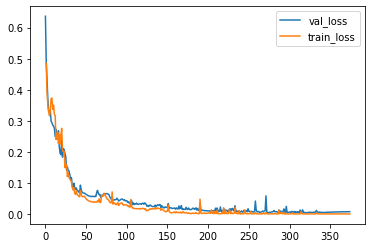

Epoch 374, step 31499: val_loss was not in top 1
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: you defined a test_step but have no test_dataloader. Skipping test loop
  warnings.warn(*args, **kwargs)


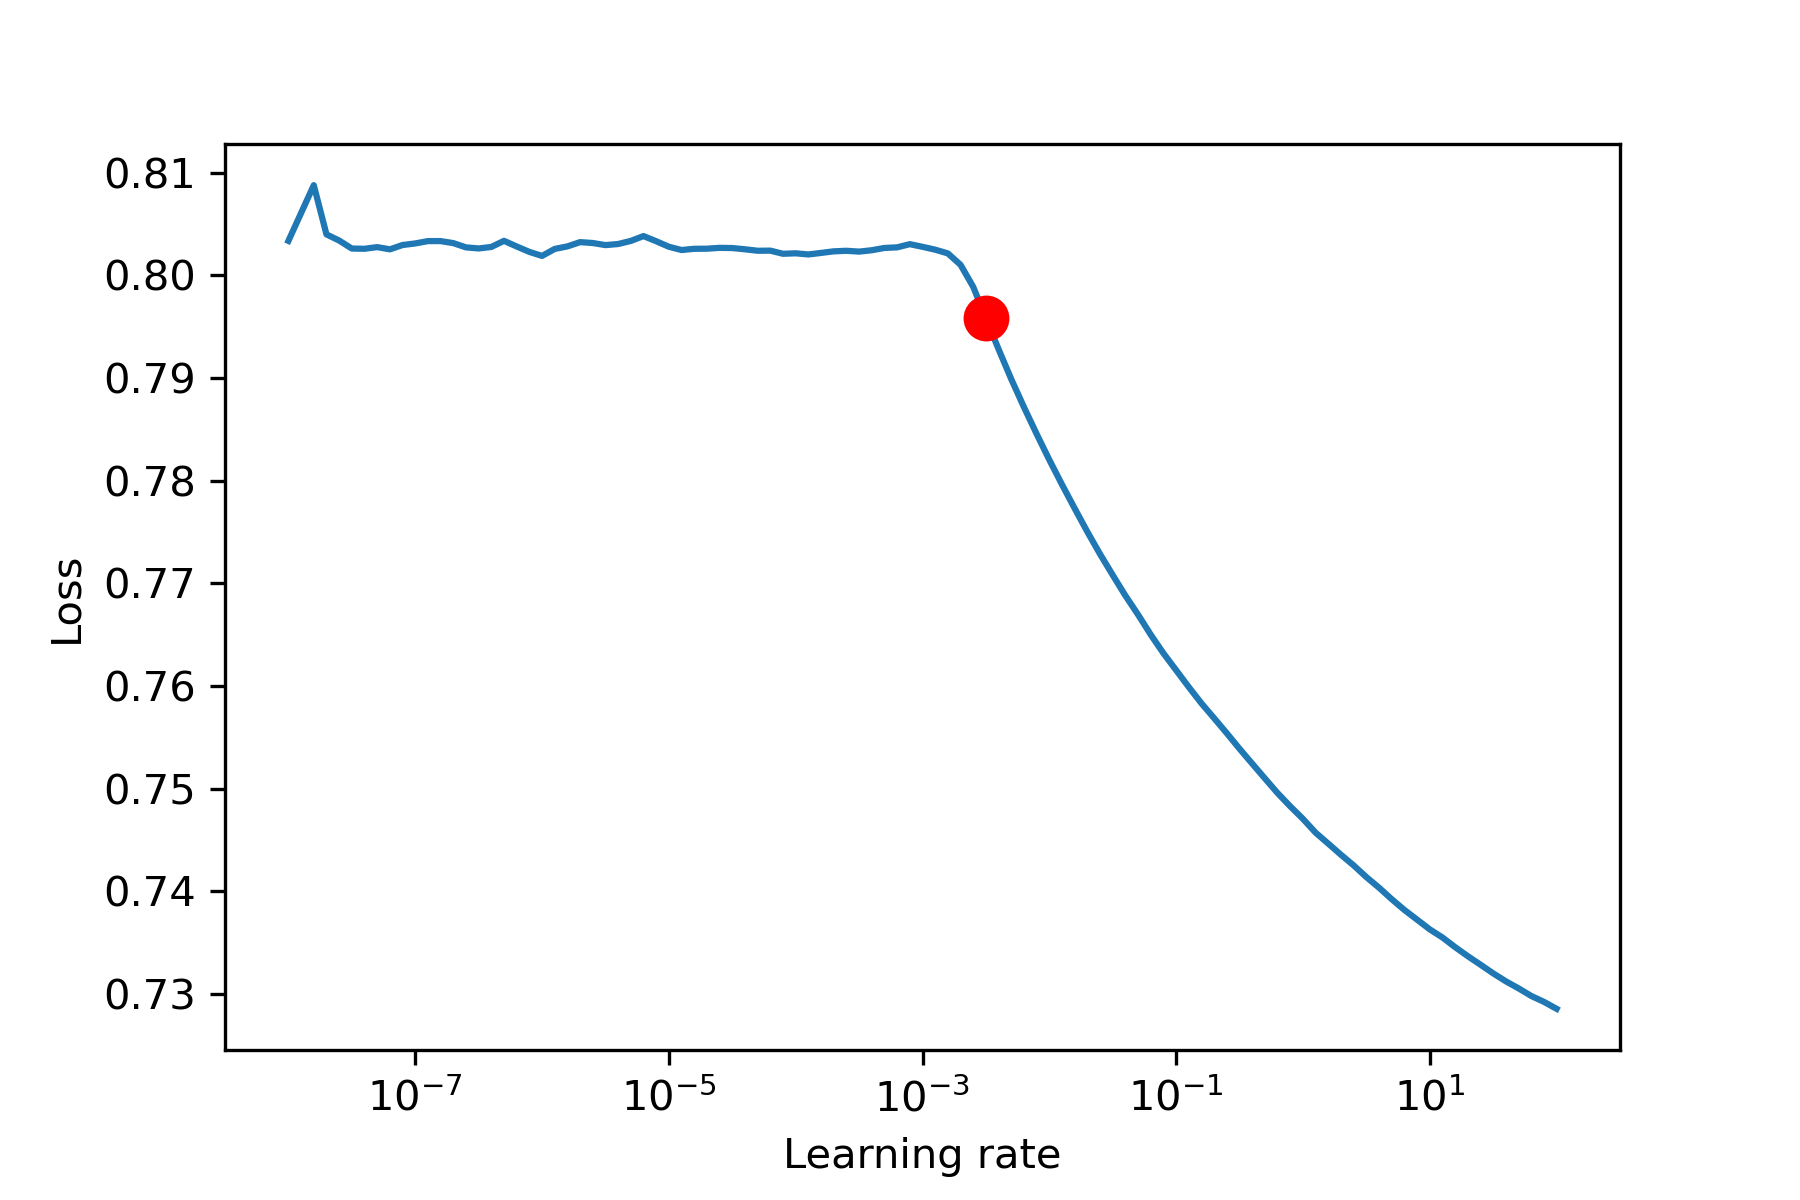

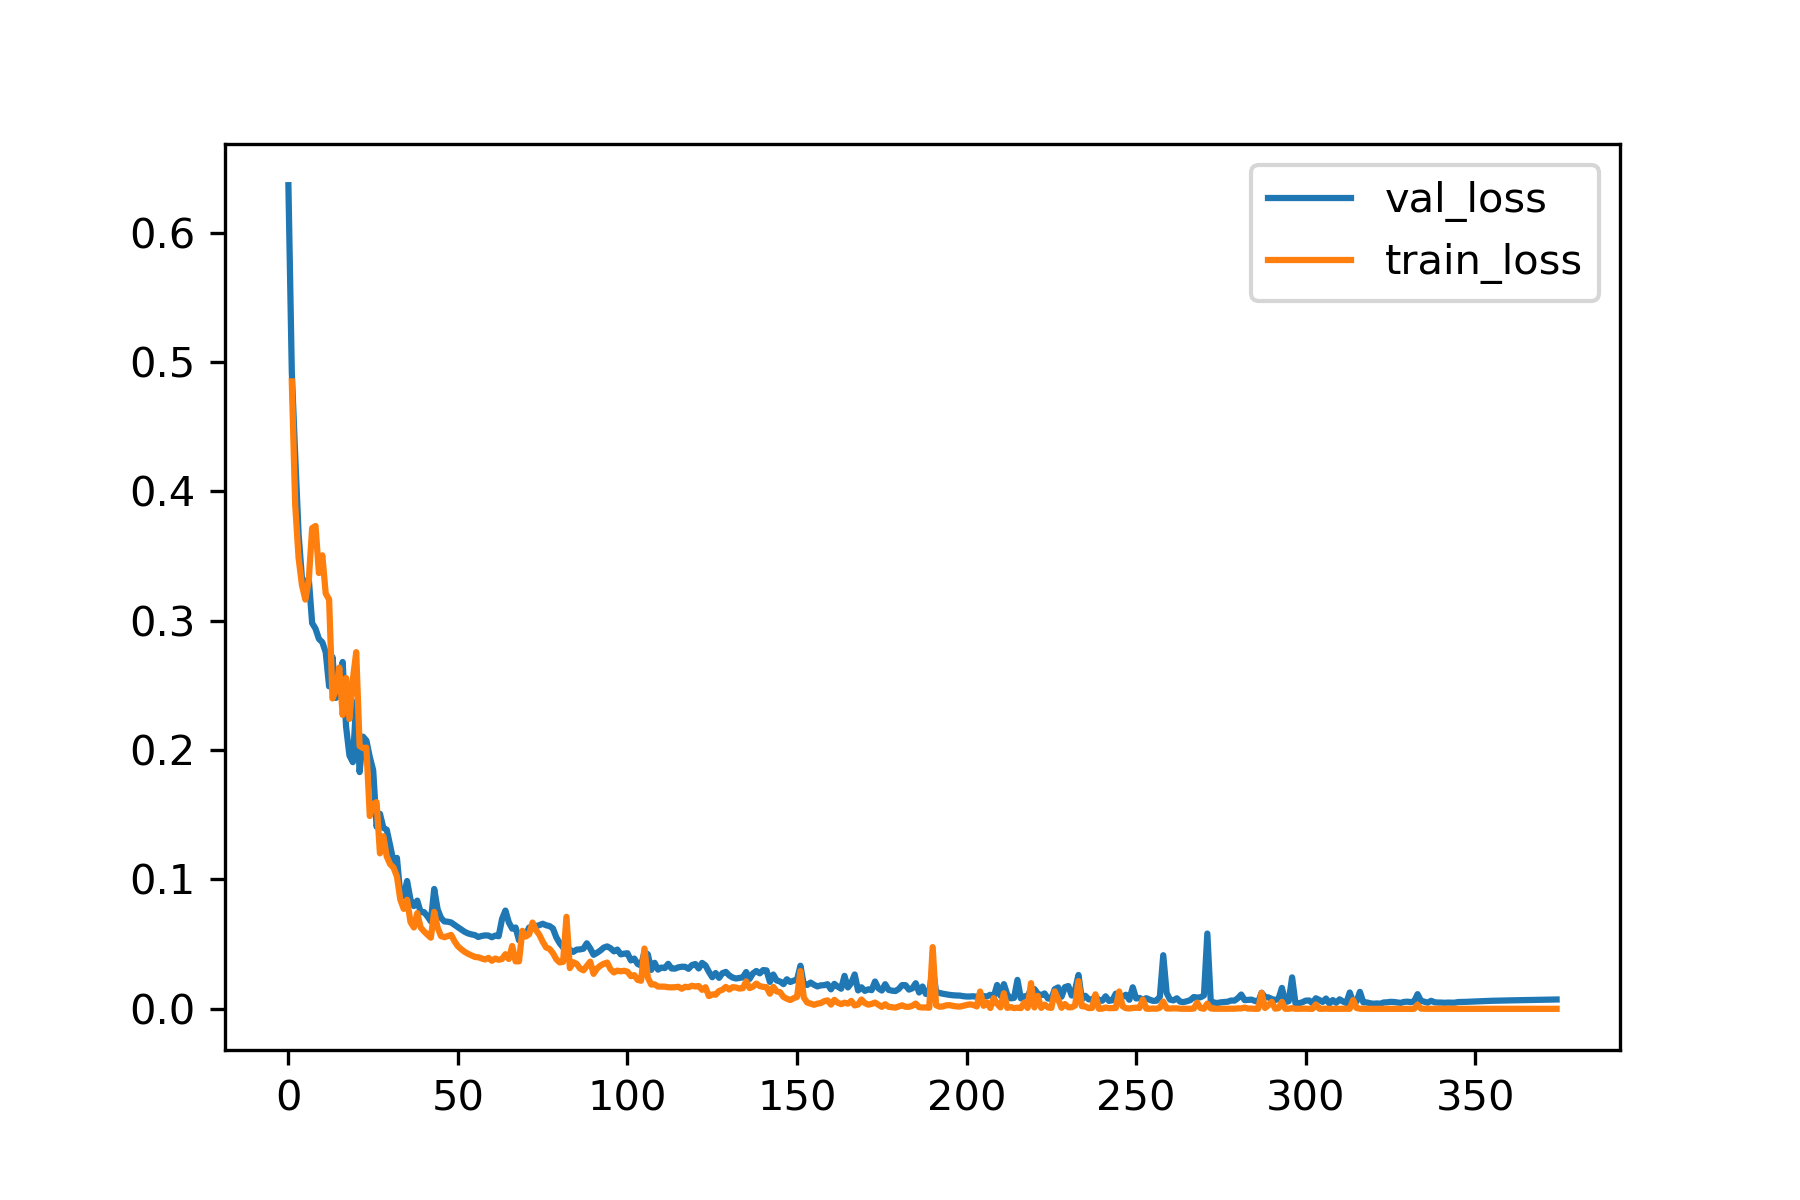

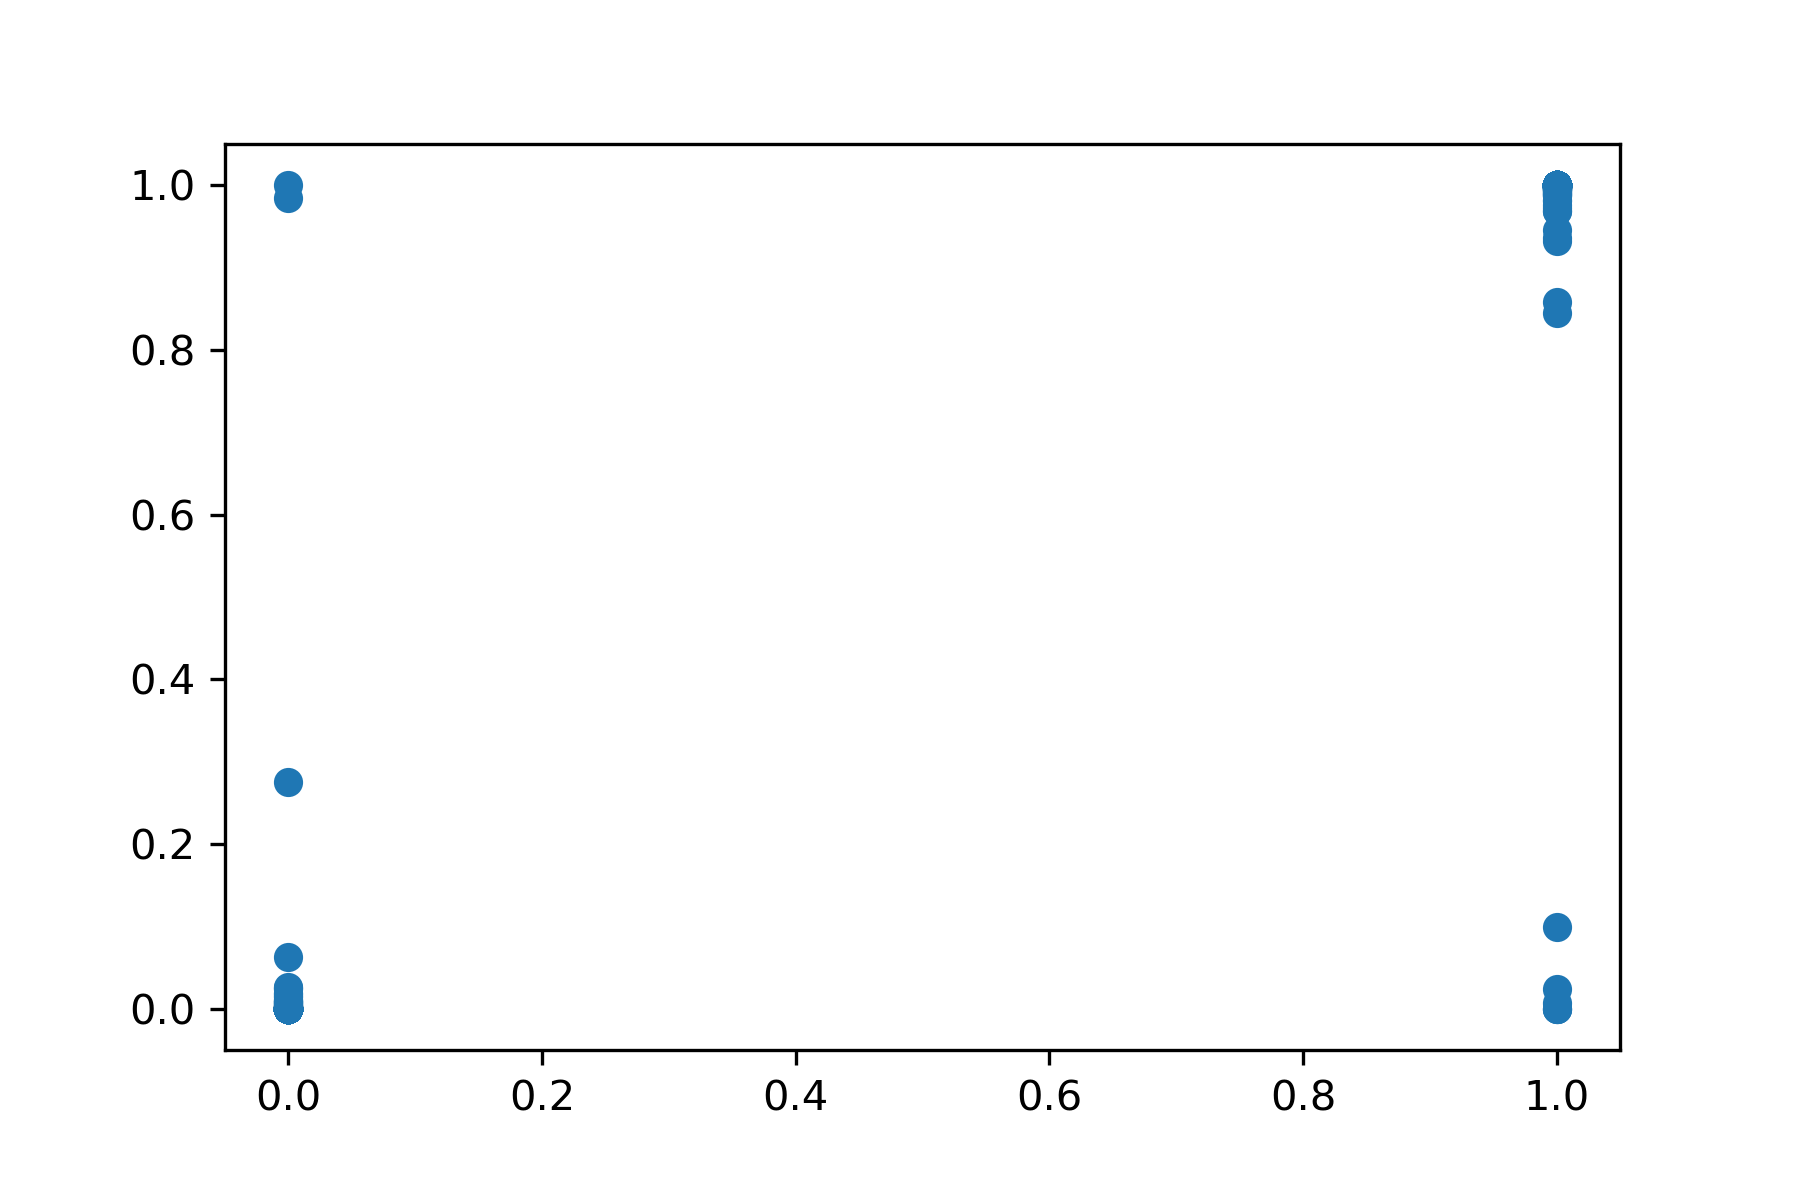

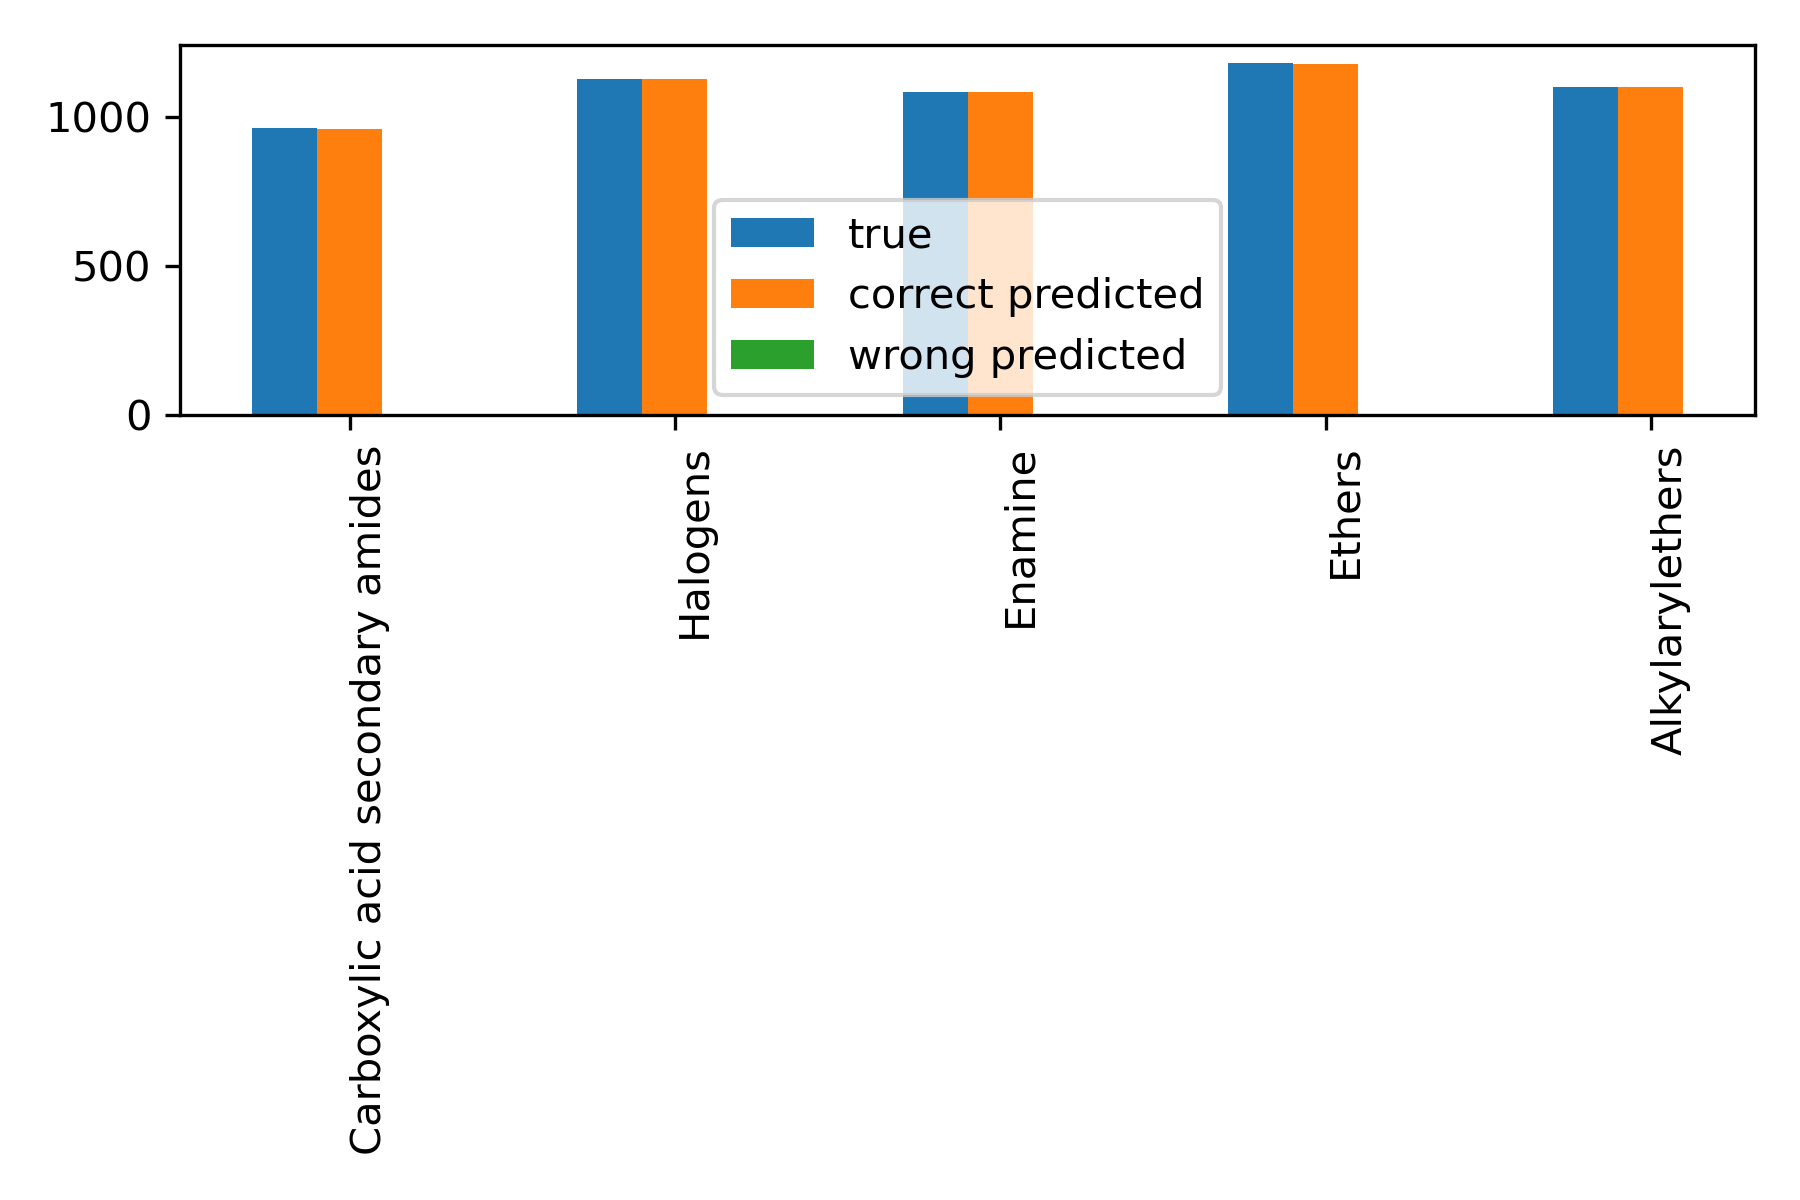

In [39]:
#model_FGModel1.lr=0.001
model_FGModel1,data_FGModel1 = bg.default_model_run(
        "FGModel1",
        model_FGModel1,
        loader_FGModel1,
                      force_run=REMODEL,
                      #force_test_data_reload=True,
                    #min_epochs=200,
                    early_stopping=True,
                    max_epochs=10000 ,
                    early_stopping_delta=0.001,
                   detect_lr=False,
                    early_stop_patience=100,
                    categories=ys,

    )

In [43]:
import numpy as np


def loader_to_list(loader,with_train=True,with_val=True,with_test=True):
    if isinstance(loader,list):
        return loader
    l=[]
    if with_train:
        l.append(loader.train_dataloader())
    if with_val:
        l.append(loader.val_dataloader())
    if with_test:
        l.append(loader.test_dataloader())
    return l

def loader_to_data_list(loader):
    dl=[]
    for l in loader_to_list(loader):
        for batch in l:
            dl.extend(batch.to_data_list())
    return dl

def get_data_attribute(data,prediction):
    try:
        prediction_size=prediction.flatten().size()[0]
    except:
        prediction_size=prediction.flatten().size
        
    if data.y.detach().cpu().numpy().flatten().size==prediction_size:
        return "y"
    elif data.y_graph_features.detach().cpu().numpy().flatten().size==prediction_size:
        return "y_graph_features"
    
def model_predict_data(model,data,as_np=False,reduce_dim=True):
    data.batch=torch.zeros(data.y.shape[0],dtype=torch.long)
    pred_m = model(data.to(model.device)).detach().cpu()
    if as_np:
        pred_m = pred_m.numpy()
    if reduce_dim:
        pred_m = pred_m[0]
    return pred_m

def check_multiclass(model,datalist,max_check=10*5):
    multiclass=False
    attr=None
    
    for i,data in enumerate(datalist):
        if attr is None:
            predict_data = model_predict_data(model,data)
            attr=get_data_attribute(data,predict_data)

        true_data=getattr(data,attr).detach()[0]
        if true_data.sum()>1:
            multiclass=True
            break
            
        if i>max_check:
            break
            
    return multiclass

def cat_true_vs_pred(model,loader,multiclass=None,multiclass_threshold=0.5):
    false_positive_categories=[]
    false_negative_categories=[]
    true_positive_categories=[]
    true_negative_categories=[]
    truth=[]
    wrong_pred_data=[]
    correct_pred_data=[]
    
    attr=None
    
    datalist=loader_to_data_list(loader)
    if multiclass is None:
        multiclass=check_multiclass(model,datalist)
        
    for i,data in enumerate(datalist):
        predict_data = model_predict_data(model,data)
        data.prediction=predict_data
        if attr is None:
            attr=get_data_attribute(data,predict_data)
            
        predict_data=predict_data.numpy().copy()
        if multiclass:
            predict_data[predict_data<multiclass_threshold]=0
            predict_data[predict_data>0]=1
        else:
            argm=predict_data.argmax()
            predict_data[:]=0
            predict_data[argm]=1
        data.binary_prediction=predict_data
        
        true_data=getattr(data,attr).detach()[0].numpy().astype(bool)
        predict_data=predict_data.astype(bool)
        
        fp_idx = np.argwhere(predict_data&~true_data).flatten()
        fn_idx = np.argwhere(~predict_data&true_data).flatten()
        
        if len(fp_idx) or len(fn_idx):
            wrong_pred_data.append(data)
            #display(fp_idx,fn_idx)
            #display(predict_data)
            #display(true_data)
            #display(data.mol_graph.mol)
            #break
        else:
            correct_pred_data.append(data)
        
        truth.extend(np.argwhere(true_data).flatten())
        
        true_positive_categories.extend(np.argwhere(predict_data&true_data).flatten())
        true_negative_categories.extend(np.argwhere(~predict_data&~true_data).flatten())
        false_positive_categories.extend(fp_idx)
        false_negative_categories.extend(fn_idx)
        
        
        
    
    return dict(truth=np.array(truth),
                true_positive_categories=np.array(true_positive_categories),
                true_negative_categories=np.array(true_negative_categories),
                false_positive_categories=np.array(false_positive_categories),
                false_negative_categories=np.array(false_negative_categories),
                wrong_pred_data=wrong_pred_data,
                correct_pred_data=correct_pred_data,
               )    

cat_pred_data=cat_true_vs_pred(model_FGModel1,loader_to_list(loader_FGModel1,with_train=False),multiclass=True,multiclass_threshold=0.75)

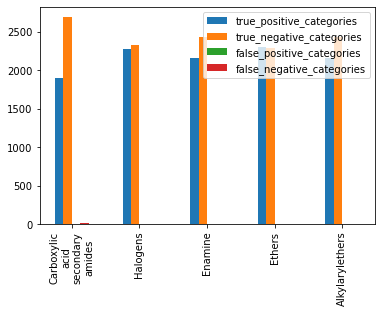

In [44]:
import matplotlib.pyplot as plt
labels=["true_positive_categories","true_negative_categories","false_positive_categories","false_negative_categories"]
width=0.5/len(labels)
fig, ax = plt.subplots()
x = np.arange(len(ys))
ax.set_xticks(x)
ax.set_xticklabels([y.replace(" ","\n") for y in ys], rotation=90)


for i,l in enumerate(labels):
    counts=np.zeros(x.shape[0],dtype=int)
    cats,_counts =np.unique(cat_pred_data[l],return_counts=True)
    if len(cats)>0:
        counts[cats]=_counts
    bars = plt.bar(x-(len(labels)-1)*width/2+i*width, counts,width,label=l)

ax.legend()
plt.show()
plt.close()

tensor([3.0082e-01, 1.8095e-16, 1.9550e-07, 7.8288e-08, 6.6182e-11])

array([0., 0., 0., 0., 0.], dtype=float32)

tensor([1., 0., 0., 0., 0.])

'C[C@H]1CC(=O)NN=C1/C=C/c1ccc2c(c1)C(C)(C)C(=O)N2'

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 0.])

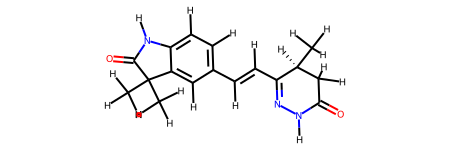

tensor([2.7279e-03, 1.1987e-13, 7.9452e-06, 1.3118e-06, 5.3061e-10])

array([0., 0., 0., 0., 0.], dtype=float32)

tensor([1., 0., 0., 0., 0.])

'CN1C(=O)[C@@H](c2ccccc2)NC(=O)/C1=C\\c1c[nH]c2ccccc12'

tensor([0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 1., 1., 1., 1.])

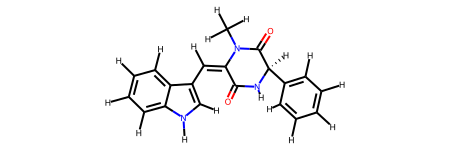

tensor([1.1266e-04, 6.5646e-14, 4.9411e-01, 4.8987e-06, 4.4752e-03])

array([0., 0., 0., 0., 0.], dtype=float32)

tensor([1., 0., 1., 0., 0.])

'COC1=NOC[C@@H]1NC(=O)c1ccccc1C(=O)O'

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.])

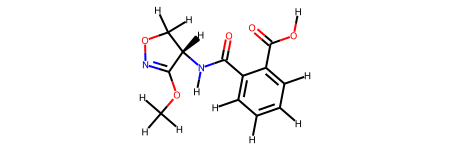

tensor([9.9938e-01, 1.0000e+00, 2.2342e-04, 1.3841e-01, 5.9906e-12])

array([1., 1., 0., 0., 0.], dtype=float32)

tensor([1., 1., 0., 1., 0.])

'O=C1CO[C@H](c2ccc(C(F)(F)F)cc2)CN1'

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 1., 0.])

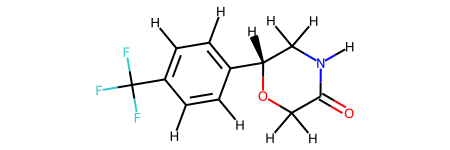

tensor([9.9814e-01, 1.0000e+00, 9.6750e-01, 6.9474e-12, 1.6807e-08])

array([1., 1., 1., 0., 0.], dtype=float32)

tensor([0., 1., 0., 0., 0.])

'N=C1C(Cl)=C(N)C(=O)c2[nH]cc([C@H](O)CO)c21'

tensor([0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 0.])

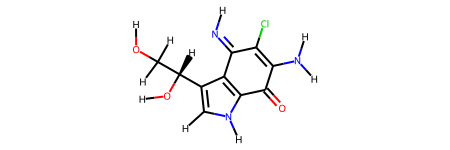

tensor([6.8564e-01, 1.0000e+00, 3.4903e-03, 2.8276e-11, 1.8829e-13])

array([0., 1., 0., 0., 0.], dtype=float32)

tensor([1., 1., 0., 0., 0.])

'C=C(C)OC(=O)N1c2cc(Cl)ccc2NC(=O)[C@@H]1CC'

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1.])

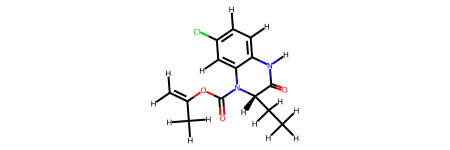

tensor([7.1783e-17, 1.2449e-11, 2.1425e-10, 9.6782e-01, 9.5485e-01])

array([0., 0., 0., 1., 1.], dtype=float32)

tensor([0., 0., 0., 1., 0.])

'Cc1c(C)c2c(c(C)c1O)CN(CCCN1CCOCC1)CO2'

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

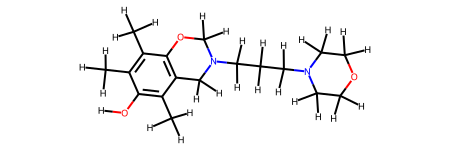

tensor([1.7967e-04, 1.6567e-11, 2.8288e-03, 9.9993e-01, 9.9993e-01])

array([0., 0., 0., 1., 1.], dtype=float32)

tensor([1., 0., 0., 1., 1.])

'CS[C@@H]1NC(=O)/C(=C/c2ccc(OCC=C(C)C)cc2)NC1=O'

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0.])

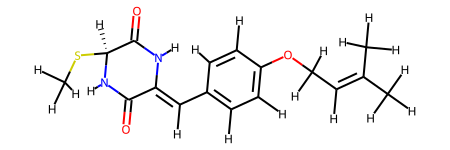

tensor([3.8413e-14, 1.0000e+00, 2.3387e-11, 5.4039e-05, 2.4512e-11])

array([0., 1., 0., 0., 0.], dtype=float32)

tensor([0., 1., 0., 1., 0.])

'O=c1oc(Oc2ccc(Cl)cc2)nn1-c1ccccc1Cl'

tensor([1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0.])

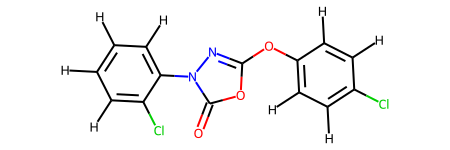

tensor([3.2520e-14, 1.0000e+00, 2.1075e-11, 2.4236e-02, 1.4768e-03])

array([0., 1., 0., 0., 0.], dtype=float32)

tensor([0., 1., 0., 1., 0.])

'COC1=CC(=O)O[C@@H]1[C@H](OC)c1ccccc1Cl'

tensor([0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.])

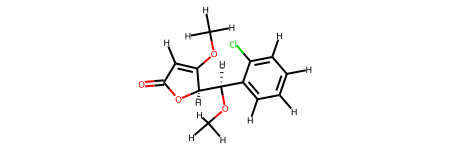

tensor([7.6449e-03, 1.0000e+00, 8.5855e-01, 5.8367e-08, 1.9853e-10])

array([0., 1., 1., 0., 0.], dtype=float32)

tensor([1., 1., 1., 0., 0.])

'O=C1NN=C(c2ccc(NC(=O)c3cccc(F)n3)cc2)CO1'

tensor([0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.])

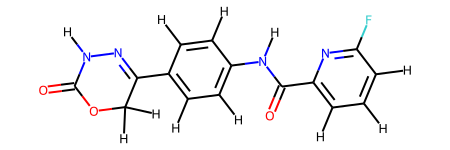

tensor([1.0000e+00, 1.4687e-15, 1.0000e+00, 7.5744e-14, 1.7201e-16])

array([1., 0., 1., 0., 0.], dtype=float32)

tensor([0., 0., 1., 0., 0.])

'N[C@H](CSC(=O)Nc1ccccc1)Cc1ccccc1'

tensor([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
        0., 1.])

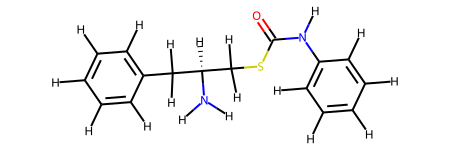

tensor([2.9822e-11, 1.2435e-08, 9.8453e-01, 1.9611e-10, 1.8854e-11])

array([0., 0., 1., 0., 0.], dtype=float32)

tensor([0., 0., 0., 0., 0.])

'CN(/N=N/N(C)c1ccccc1)c1ccccc1'

tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1.])

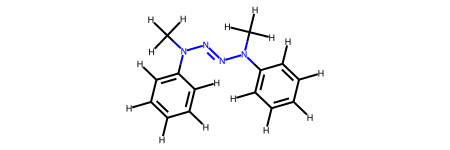

tensor([5.3390e-05, 2.3552e-09, 1.0000e+00, 1.0000e+00, 1.0000e+00])

array([0., 0., 1., 1., 1.], dtype=float32)

tensor([1., 0., 1., 1., 1.])

'C=C(NC(=O)Cc1ccc(OC)cc1)C(=O)O'

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.])

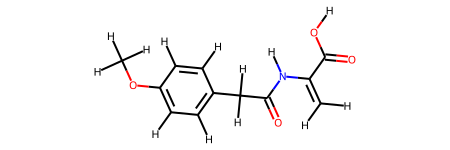

tensor([5.3390e-05, 2.3552e-09, 1.0000e+00, 1.0000e+00, 1.0000e+00])

array([0., 0., 1., 1., 1.], dtype=float32)

tensor([1., 0., 1., 1., 1.])

'C=C(NC(=O)Cc1ccc(OC)cc1)C(=O)O'

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.])

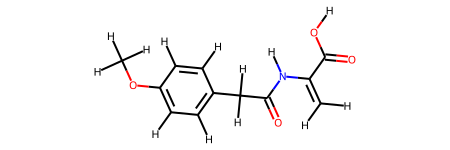

tensor([4.3503e-12, 7.6114e-10, 7.3360e-11, 9.8881e-02, 7.9989e-09])

array([0., 0., 0., 0., 0.], dtype=float32)

tensor([0., 0., 0., 1., 0.])

'C/C=C1\\c2ccccc2C2=NCC[C@H]3O[C@]213'

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.])

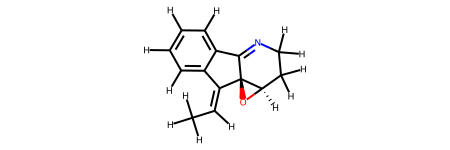

In [45]:
for i,wpd in enumerate(cat_pred_data["wrong_pred_data"]):
    #if wpd.binary_prediction[4]!=wpd.y_graph_features[0][4]:
    display(wpd.prediction)
    display(wpd.binary_prediction)
    display(wpd.y_graph_features[0])
    display(wpd.mol_graph.molecule.smiles)
    display(wpd.x[:,-1])
    display(wpd.mol_graph.mol)

    
    #break
    

In [ ]:
true = []
pred_correct = []
pred_wrong = []
wrong_data=[]
attr=None

for i, d in enumerate(loader.test_dataloader()):
    pred_m = model(d.to(model.device)).detach().cpu().numpy()
    if attr is None:
        if d.y.detach().cpu().numpy().flatten().size==pred_m.size:
            attr="y"
        elif d.y_graph_features.detach().cpu().numpy().flatten().size==pred_m.size:
            attr="y_graph_features"


    true_vector=getattr(d,attr).detach().cpu().numpy()
    if true_vector.sum()==1:
        p = pred_m.argmax(1)
        t = true_vector.argmax(1)
        pred_correct.extend(p[p == t])
        wr=p[p != t]
        if any(wr):
            wrong_data.extend()
        pred_wrong.extend()
        true.extend(t)
    else:
        for row in range(true_vector.shape[0]):
            tv = (true_vector[row]==1)
            true.extend(np.argwhere(tv).flatten())
            pv = pred_m[row]>=threshold
            pred_correct.extend(np.argwhere(tv&pv).flatten())
            pred_wrong.extend(np.argwhere(tv&~pv).flatten())
            pred_wrong.extend(np.argwhere(~tv&pv).flatten())

In [ ]:
loader=loader_FGModel1
for i, batch in enumerate(loader.test_dataloader()):
    print()
    break

In [ ]:
model_FGModel1

In [ ]:
for batch in loader_FGModel1.val_dataloader():
    #print(batch)
    pred=ysa[model_FGModel1(batch).detach().numpy()[0]>0.5]
    tr=ysa[batch.y_graph_features[0].numpy().astype(bool)]
    l1=len(pred)
    l2=len(tr)
    if l1+l2>0 and ((l1!=l2) or not all(tr==pred)):
        print(tr==pred)
        print(ysa[batch.y_graph_features[0].numpy().astype(bool)], ysa[model_FGModel1(batch).detach().numpy()[0]>0.5])
    

In [ ]:
import numpy as np
#list(model_FGModel1.parameters())
model_parameters = filter(lambda p: p.requires_grad, model_FGModel1.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

In [ ]:
true=[]
pred=[]
try:
    loader_FGModel1.train_dataloader()
except:
    loader_FGModel1.setup()
    
for l in [
        loader_FGModel1.train_dataloader(),
          loader_FGModel1.val_dataloader(),
          loader_FGModel1.test_dataloader()
         ]:
    for d in l:
        pred.extend(model_FGModel1(d).detach().flatten().numpy().tolist())
        true.extend(d.y.flatten().numpy().tolist())
        
    #print(()-np.exp(d.y.numpy())).mean())

pred=np.array(pred)
true=np.array(true)

In [ ]:
import matplotlib.pyplot as plt

dmin=min(true.min(),pred.min())
dmax=max(true.max(),pred.max())

plt.plot([dmin-273,dmax-273],[dmin-273,dmax-273],"--")
plt.plot(true-273,pred-273,"o",alpha=0.3,markeredgecolor="w")
plt.xlabel("true")
plt.ylabel("pred")
plt.show()
plt.close()
#plt.plot(np.exp(pred),np.exp(true),"o")
#plt.show()
#plt.close()

In [ ]:
#print(np.abs(np.exp(pred)-np.exp(true)).mean())
print(np.abs(pred-true).mean())

In [18]:
model_FGModel1

FGModel1(
  (chem_layer): Sequential(
    (0): ChemGCLayer(
      (fcnn): Sequential(
        (0): Linear(in_features=23, out_features=23, bias=False)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=23, out_features=23, bias=False)
        (3): ELU(alpha=1.0)
      )
      (gc): GCNConv(46, 32)
      (combine): Sequential(
        (0): Linear(in_features=55, out_features=64, bias=False)
        (1): ELU(alpha=1.0)
      )
    )
    (1): ChemGCLayer(
      (fcnn): Sequential(
        (0): Linear(in_features=87, out_features=87, bias=False)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=87, out_features=87, bias=False)
        (3): ELU(alpha=1.0)
      )
      (gc): GCNConv(174, 32)
      (combine): Sequential(
        (0): Linear(in_features=119, out_features=64, bias=False)
        (1): ELU(alpha=1.0)
      )
    )
    (2): ChemGCLayer(
      (fcnn): Sequential(
        (0): Linear(in_features=151, out_features=151, bias=False)
        (1): ELU(alpha=1.0)
     

In [ ]:
import numpy as np
ysa=np.array(ys)

In [ ]:
ys

In [ ]:
dataset[dataset['Halogens'].astype(bool)][["rd_mol"]]

In [ ]:
import numpy as np
threshold=0.5

true = []
pred_correct = []
pred_wrong = []
true_vector=np.array([[0,1,1,0]])
pred_m=np.array([[0.6,0.,0.6,0.3]])

if true_vector.sum()==1:
    p = pred_m.argmax(1)
    t = true_vector.argmax(1)
    pred_correct.extend(p[p == t])
    pred_wrong.extend(p[p != t])
    true.extend(t)
else:
    for row in range(true_vector.shape[0]):
        print(row)
        tv = (true_vector[row]==1)
        true.extend(np.argwhere(tv).flatten())
        pv = pred_m[row]>=threshold
        pred_correct.extend(np.argwhere(tv&pv).flatten())
        pred_wrong.extend(np.argwhere(tv&~pv).flatten())
        pred_wrong.extend(np.argwhere(~tv&pv).flatten())


pred_correct,pred_wrong,true

In [ ]:
p